<a href="https://colab.research.google.com/github/pwatana/Neurotech_UofT_2024/blob/main/Neurotech_data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Condensed Step-by-Step Process with Relevant `scipy` imports

1. **Drift Removal**  
   - **Process:** Remove channel drift using a moving average filter. \\
     from scipy.signal import lfilter


2. **Bandpass Filter (1-30 Hz)**  
   - **Process:** Apply a bandpass FIR filter to remove very slow and fast fluctuations.
     \\ from scipy.signal import firwin, filtfilt

3. **Segmentation with Overlapping Windows**  
   - **Process:** Segment data using 3-second overlapping Hamming windows with 90% overlap.
     \\ from scipy.signal import hamming

4. **Autoregressive (AR) Spectrum Estimation**  
   - **Process:** Use a sixth-degree autoregressive model to calculate the frequency spectrum.
     \\ from spectrum import aryule ???

5. **Peak Power and Tremor Detection**  
   - **Process:** Find peaks in the frequency spectrum within the 3–8 Hz range and label tremor windows.
     \\ from scipy.signal import find_peaks

6. **Threshold Filtering for Low-Amplitude Vibrations**  
   - **Process:** Keep tremor-labeled windows with a peak frequency > T.

7. **Upsample Results**  
   - **Process:** Match the length of original accelerometer data by upsampling.
     \\ from scipy.signal import resample

8. **Smoothing to Eliminate Transient Perturbations**  
   - **Process:** Smooth the upsampled data.
     \\ from scipy.ndimage import gaussian_filter1d

9. **Combine Axes (X, Y, Z)**  
   - **Process:** Multiply the results of the three axes to preserve tremor information.



# Install packages and libraries

In [4]:
# imports
import mne
import pickle
import numpy as np
import pandas as pd

from spectrum import aryule, arma2psd
from scipy import signal
from scipy.signal import find_peaks
from scipy.signal.windows import hamming
from scipy.signal import find_peaks, firwin
from scipy.signal import lfilter
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import windows
from scipy.signal.windows import hamming

Import and visualize data

In [ ]:
# Extracting the accelerometer data from the kaggle dataset
# Load the dataset
file_path = "/Users/patriciawatanabe/Desktop/Neurotech_UofT_2024/data/Hand_Tremor_Kaggle.csv"
df = pd.read_csv(file_path)
# df.info(), df.head()

df_accel = df[['aX', 'aY', 'aZ']].astype('float64')
df_accel.info(), df_accel.head()

accelerometer_data = df_accel.T.values.astype(np.float32)
accelerometer_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27995 entries, 0 to 27994
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   aX      27995 non-null  float64
 1   aY      27995 non-null  float64
 2   aZ      27995 non-null  float64
dtypes: float64(3)
memory usage: 656.3 KB


array([[ -2544.,  -2380.,   -524., ...,  -5144.,  -5052.,  -5072.],
       [ 14340.,  14188.,  14480., ...,   1108.,   1892.,   1060.],
       [ -6864.,  -5644.,  -7148., ..., -15100., -14688., -15048.]],
      dtype=float32)

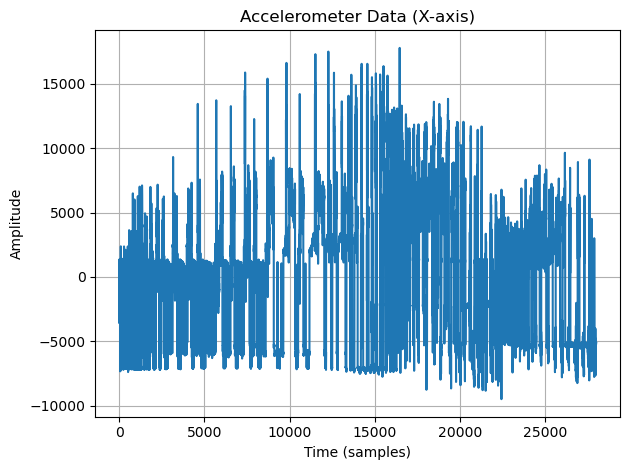

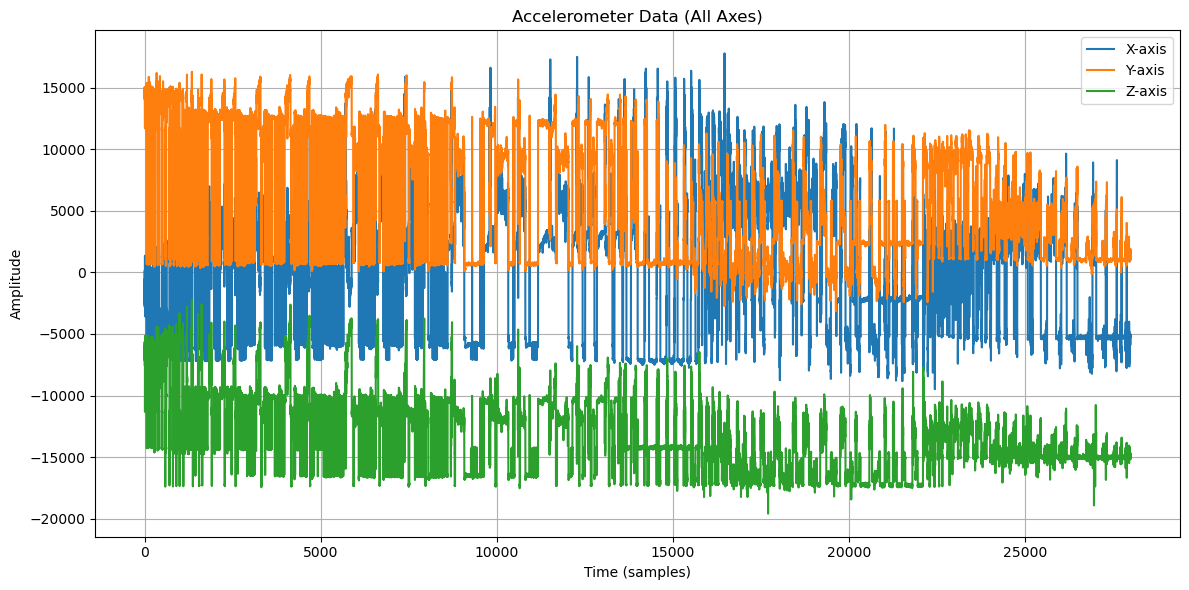

In [7]:
# visualize accelerometer data for one axis

# Create x-axis values for the time indices
# Observe first row
x = list(range(len(accelerometer_data[0])))
plt.plot(x, accelerometer_data[0])
plt.title('Accelerometer Data (X-axis)')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.grid(True)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Plot all axes for visualization
plt.figure(figsize=(12, 6))
axis_labels = ['X-axis', 'Y-axis', 'Z-axis']  # Labels for the axes

for i in range(accelerometer_data.shape[0]):  # Iterate over the rows (axes)
    plt.plot(x, accelerometer_data[i], label=axis_labels[i])  # Plot each axis with a label

# Add plot labels and legend
plt.title('Accelerometer Data (All Axes)')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()  # Show the legend with axis labels
plt.grid(True)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()



1. Drift Removal

Moving average filter to smooth out frequencies, window size > 50 would be good?

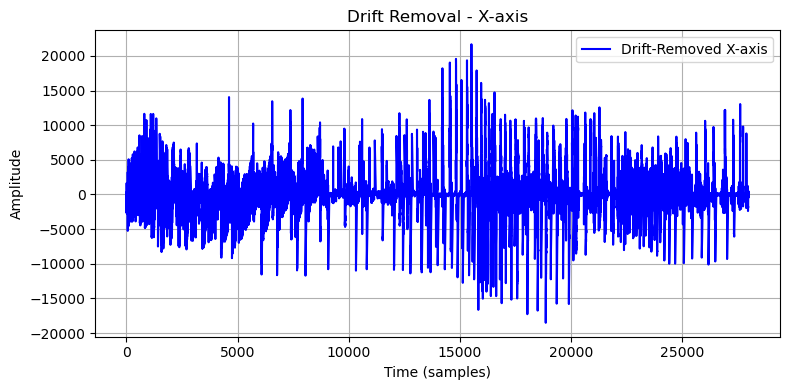

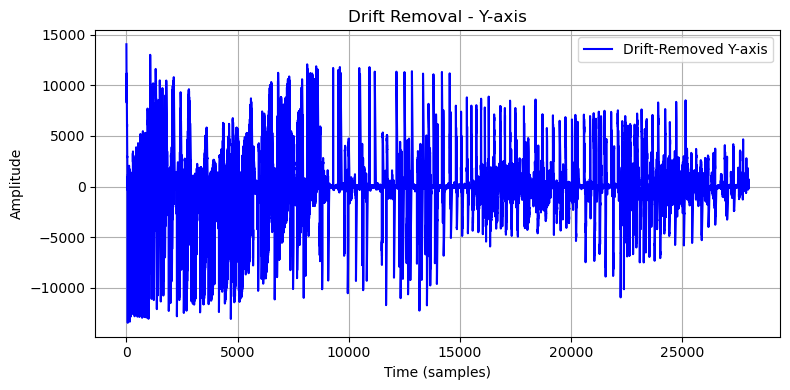

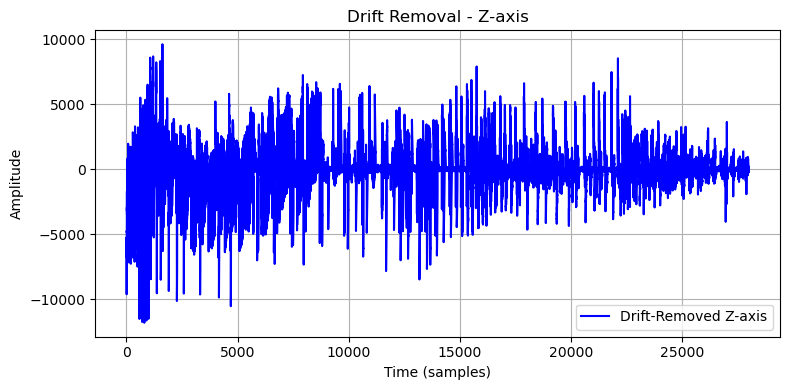

In [8]:
# Define moving average filter
def moving_average_filter(data, window_size=50):
    """
    Removes drift by subtracting a moving average from the signal.
    Args:
        data: 1D array, accelerometer data for one axis.
        window_size: Number of samples for the moving average window.
    Returns:
        Data with drift removed.
    """
    b = np.ones(window_size) / window_size  # Moving average coefficients
    a = [1]  # No feedback
    smoothed_data = lfilter(b, a, data)
    drift_removed = data - smoothed_data  # Subtract moving average from original data
    return drift_removed

# Example application
drift_removed_data = []

for axis_data in accelerometer_data:  # Loop over X, Y, Z axes
    filtered_axis = moving_average_filter(axis_data, window_size=50)
    drift_removed_data.append(filtered_axis)

# Convert back to NumPy array
drift_removed_data = np.array(drift_removed_data)

# Plot all axes after drift removal
# Labels for the axes
axis_labels = ['X-axis', 'Y-axis', 'Z-axis']

# Loop through each axis and plot them separately
for i, label in enumerate(axis_labels):  # Iterate through axes and their labels
    plt.figure(figsize=(8, 4))  # Adjust figure size
    plt.plot(drift_removed_data[i], label=f'Drift-Removed {label}', color='blue')
    plt.title(f"Drift Removal - {label}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)  # Add grid for better visualization
    plt.tight_layout()  # Prevent overlapping of elements
    plt.show()

2. Bandpass Filtering

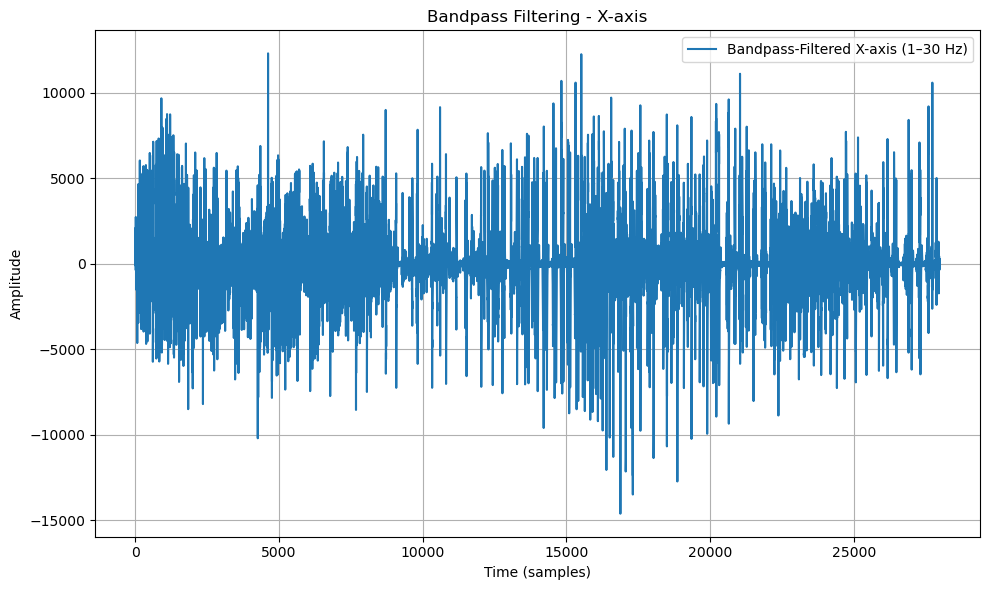

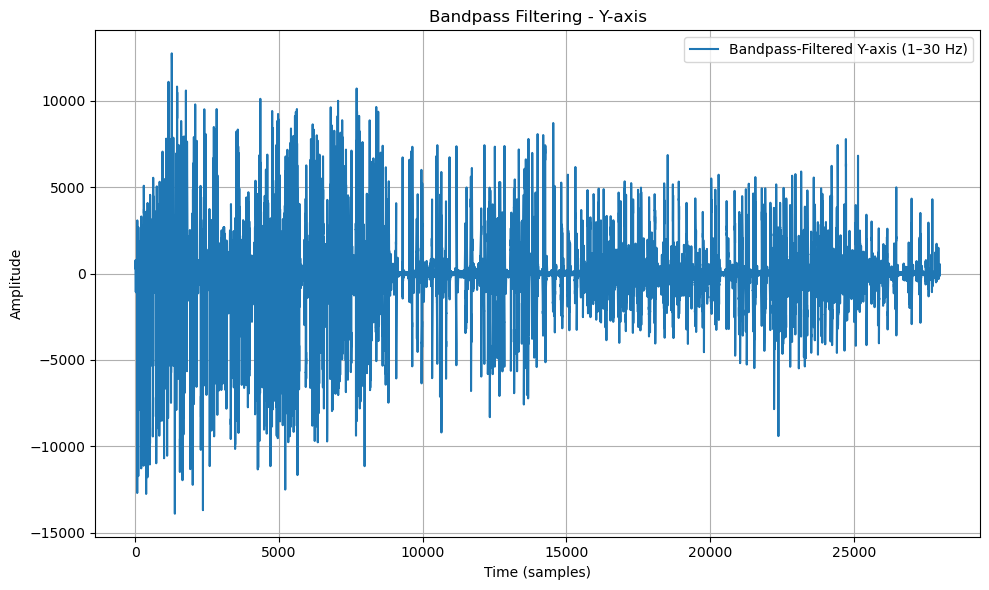

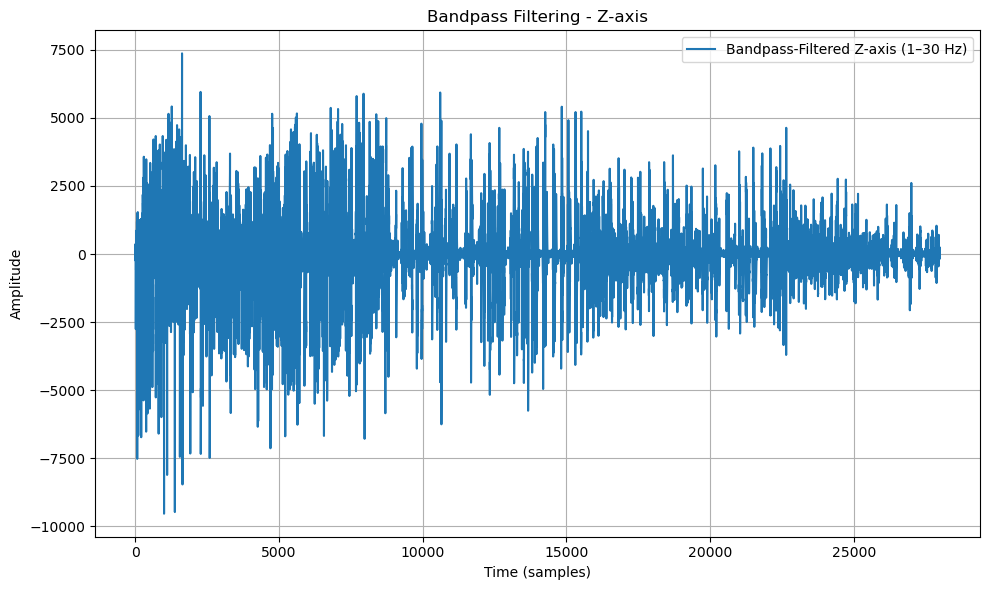

In [9]:
# Filters out irrelevant frequency components. This step isolates the frequency range (1–30 Hz) where the tremors are likely to occur, eliminating slow baseline trends and high-frequency noise.
# So our objective is to - remove any frequency above 30Hz and below 1Hz, only keep 1-30Hz which is what we are interested
# For this we use bandpass filter which is an amazing function because it does exactly what we want:
# It keeps only the frequencies between two specified cutoff frequencies (1–30 Hz) and removes everything else.

# Define bandpass_filter function
def bandpass_filter(data, fs, lowcut, highcut, numtaps=101):
    """
    Bandpass filter using FIR (finite impulse response) filter with firwin.

    Args:
        data: 1D array of the signal to filter (e.g., accelerometer or EEG data).
        fs: Sampling frequency in Hz.
        lowcut: Lower cutoff frequency in Hz.
        highcut: Upper cutoff frequency in Hz.
        numtaps: Number of filter taps (higher value = sharper frequency cutoff).

    Returns:
        Filtered data with only frequencies in the [lowcut, highcut] range.
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist  # Normalize lower cutoff
    high = highcut / nyquist  # Normalize upper cutoff

    # Design the FIR bandpass filter
    taps = firwin(numtaps, [low, high], pass_zero=False)  # Bandpass filter

    # Apply the filter to the data using filtfilt for zero phase distortion
    filtered_data = filtfilt(taps, [1.0], data)
    return filtered_data

# Example application
fs = 100  # Sampling frequency (Hz)
lowcut = 1  # Lower bound of the bandpass filter (Hz)
highcut = 30  # Upper bound of the bandpass filter (Hz)

# Apply bandpass filter to all axes (X, Y, Z)
bandpass_filtered_data = []
for axis_data in drift_removed_data:  # Use drift-removed data as input
    filtered_axis = bandpass_filter(axis_data, fs, lowcut, highcut, numtaps=101)
    bandpass_filtered_data.append(filtered_axis)

# Convert back to NumPy array
bandpass_filtered_data = np.array(bandpass_filtered_data)

# Plotting the result for the first axis
# Labels for the axes (e.g., X, Y, Z)
axis_labels = ['X-axis', 'Y-axis', 'Z-axis']

# Loop through each axis and plot separately
for i, label in enumerate(axis_labels):  # Loop over indices and labels
    plt.figure(figsize=(10, 6))  # Create a new figure for each axis
    plt.plot(bandpass_filtered_data[i], label=f"Bandpass-Filtered {label} (1–30 Hz)")
    plt.title(f"Bandpass Filtering - {label}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)  # Add a grid
    plt.tight_layout()  # Adjust layout
    plt.show()

# Important things to note here is that: this chunk of code error is totally dependent on the value of the parameters you set,
# especially fs, that is used to normalize the lowcut and highcut values upon setting the nyquist
# this normalization is necessary and has the rule 0<normalized lowcut<normalized highcut<nyquist frequency
# nyquist frequency is fs/2 and is the highest frequency that can be accurately captured when sampling a signal
# and this is equal to the half of the sampling rate fs
# so basically it represents the highest frequency that can be repersented without distortion (aliasing)
# which is very important to understand when dealing with our data

# The bandpass filtering seems to have worked nicely! You can see it in the graph, we got rid of the
# extremely high or low frequencies and the baseline is even more stable compared to just having the moving average
# and just from the visualization, I don't think we have some extremely high or low frequency that interfere with the
# stability of our baseline or the consistent amplitude change (maybe we could check but I will do this some other time)

3. Windowing with hamming function

Segmented Signal Shape (axes x windows x samples): (3, 956, 300)


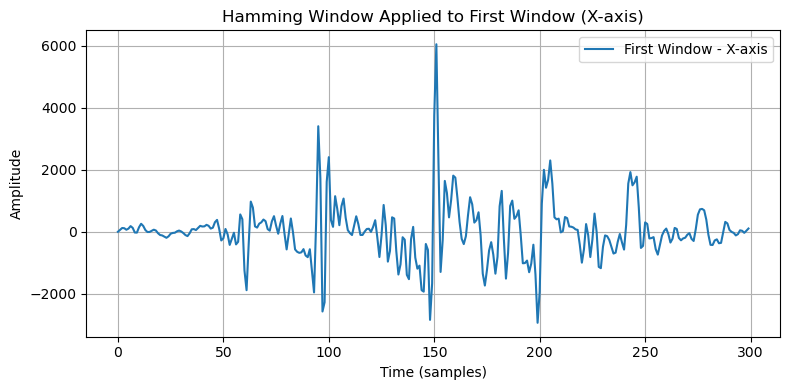

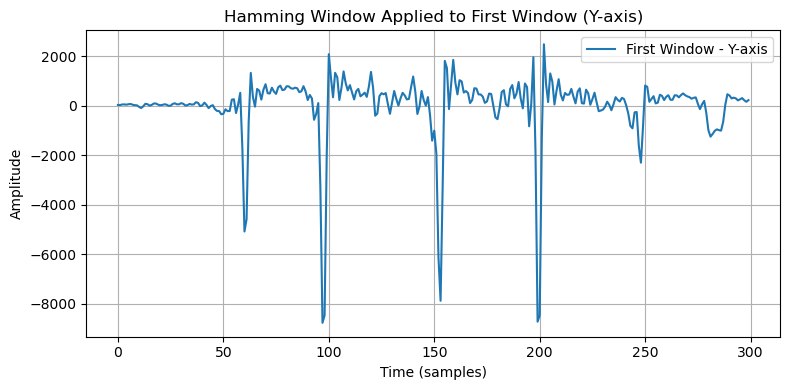

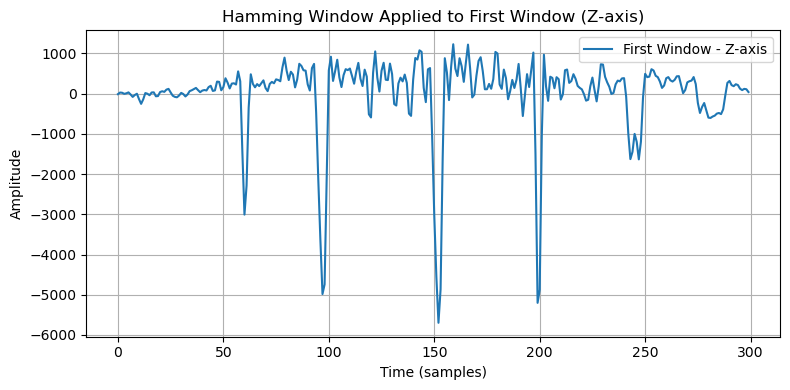

In [10]:
# Segments the signal into overlapping windows for localized analysis. The Hamming window emphasizes central samples, a common technique to minimize spectral leakage in the frequency domain.

# define segments with hamming function
def segment_with_hamming(signal, window_size, overlap, fs):
    """
    Segments the signal into overlapping windows and applies a Hamming window.

    Args:
        signal: 1D array, input signal (e.g., bandpass-filtered data).
        window_size: Duration of each window in seconds.
        overlap: Fraction of overlap between windows (e.g., 0.5 for 50% overlap).
        fs: Sampling frequency in Hz.

    Returns:
        A 2D array of segmented and windowed data, where each row is a window.
    """
    samples_per_window = int(window_size * fs)  # Convert window size to samples
    step_size = int(samples_per_window * (1 - overlap))  # Step size for overlapping
    hamming_window = windows.hamming(samples_per_window)  # Hamming window

    # Create windows
    num_windows = (len(signal) - samples_per_window) // step_size + 1
    segments = np.array([
        signal[i:i + samples_per_window] * hamming_window
        for i in range(0, len(signal) - samples_per_window + 1, step_size)
    ])

    return segments

# Parameters
fs = 100  # Sampling frequency (Hz)
window_size = 3  # Window duration in seconds
overlap = 0.9  # 90% overlap

# Apply segmentation to all axes
segmented_signals = []  # To store segmented signals for all axes
for axis_data in bandpass_filtered_data:
    segmented_axis = segment_with_hamming(axis_data, window_size, overlap, fs)
    segmented_signals.append(segmented_axis)

# Convert the segmented signals list to a NumPy array for easier handling
segmented_signals = np.array(segmented_signals)  # Shape: (3, num_windows, window_size * fs)

# Check the shape of the result
print("Segmented Signal Shape (axes x windows x samples):", segmented_signals.shape)

# Visualization for each axis
axis_labels = ['X-axis', 'Y-axis', 'Z-axis']
for i, label in enumerate(axis_labels):
    plt.figure(figsize=(8, 4))
    plt.plot(segmented_signals[i][0], label=f"First Window - {label}")
    plt.title(f"Hamming Window Applied to First Window ({label})")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



4. Frequency Spectrum Calculation (6th-Oder Autoregressive Modeling Using Berg Method)

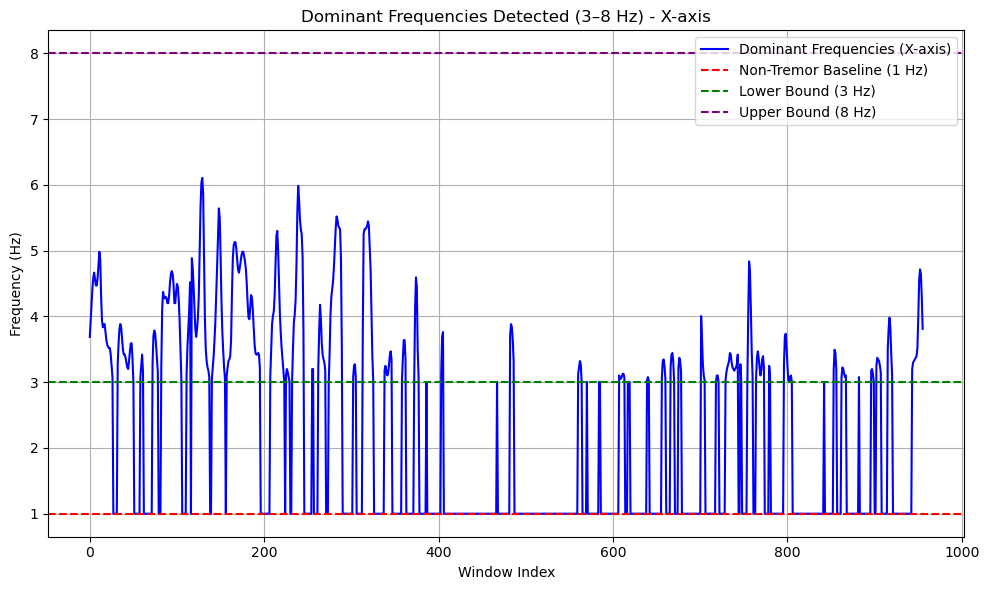

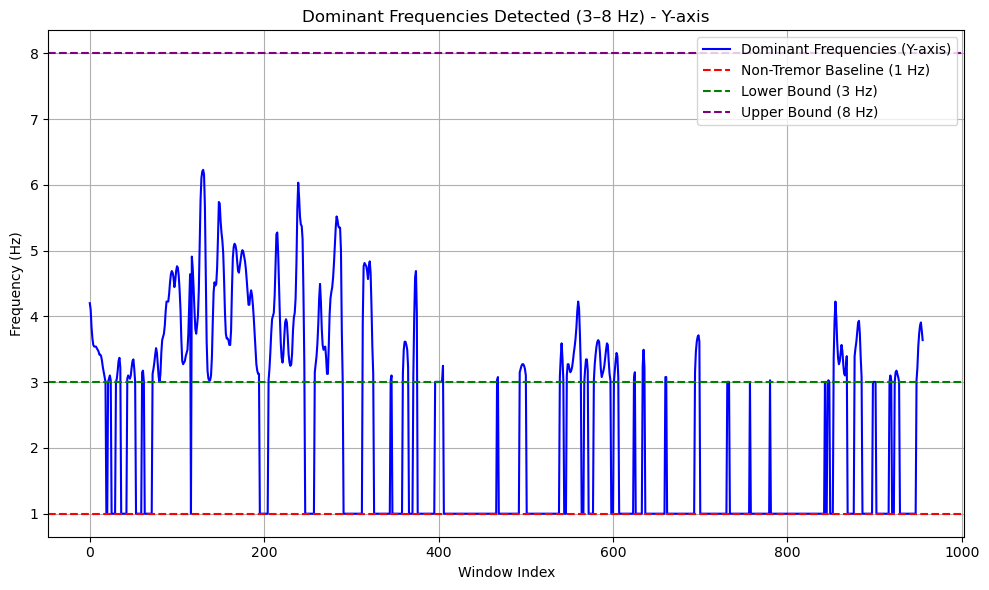

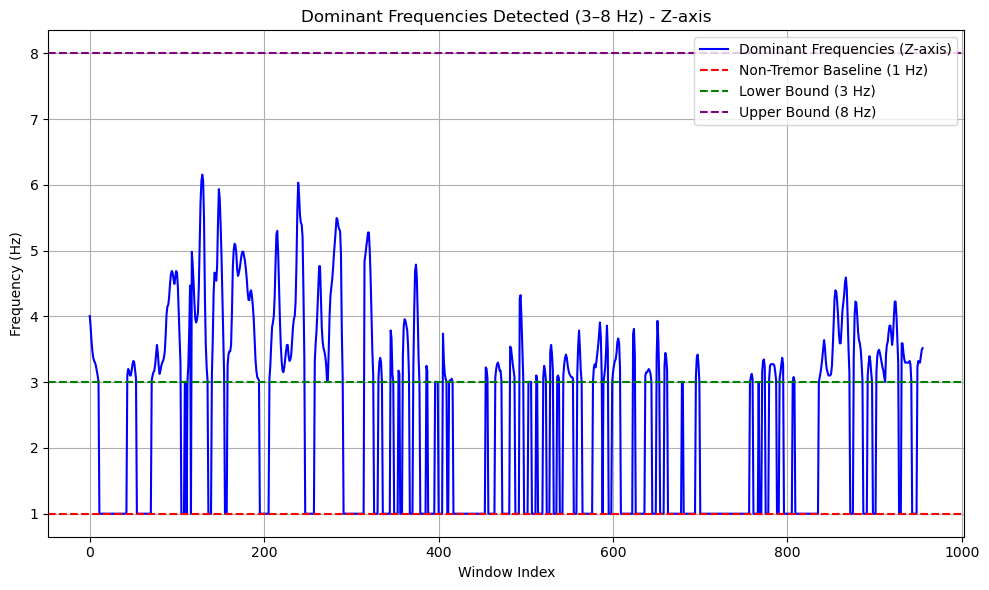

In [12]:
from spectrum import arburg, arma2psd
from scipy.signal import find_peaks

def detect_dominant_frequencies(segmented_windows, fs, low_freq=3, high_freq=8, ar_order=10, threshold_divisor=10):
    """
    Detects dominant frequencies for each window using an autoregressive model.
    Applies power spectral density (PSD) estimation and finds the dominant frequency within the 3–8 Hz tremor range.

    Args:
        segmented_windows: 2D array (num_windows x window_samples), segmented signal for one axis.
        fs: Sampling frequency in Hz.
        low_freq: Lower bound of the tremor frequency range (Hz).
        high_freq: Upper bound of the tremor frequency range (Hz).
        ar_order: Order of the autoregressive model.
        threshold_divisor: Divisor for power thresholding.

    Returns:
        dominant_frequencies: 1D array of detected dominant frequencies per segment.
        dominant_powers: 1D array of power values at detected frequencies.
    """
    dominant_frequencies = []
    dominant_powers = []

    for window in segmented_windows:
        try:
            # Step 1: Fit AR Model
            ar_coeffs, noise_variance, _ = arburg(window, ar_order)

            # Step 2: Compute PSD
            psd = arma2psd(ar_coeffs, rho=noise_variance)
            psd = psd[:len(psd) // 2]  # Keep only positive frequencies
            nfft = len(psd)
            freqs = np.linspace(0, fs / 2, nfft)

            # Step 3: Find Peaks in PSD
            peaks, _ = find_peaks(psd)

            if peaks.size > 0:
                max_peak_power = max(psd[peaks])  # Get the strongest peak power
            else:
                dominant_frequencies.append(1)  # Default to 1 Hz if no peaks
                dominant_powers.append(0)
                continue

            # Step 4: Filter Peaks in 3–8 Hz Range
            freq_peaks = freqs[peaks]
            freq_indices = (freq_peaks >= low_freq) & (freq_peaks <= high_freq)
            filtered_freqs = freq_peaks[freq_indices]

            if filtered_freqs.size > 0:
                peak_filtered_indices = np.where((freqs >= low_freq) & (freqs <= high_freq))
            else:
                dominant_frequencies.append(1)
                dominant_powers.append(0)
                continue

            # Step 5: Select the Strongest Peak
            freqs_filtered = freqs[peak_filtered_indices]
            psd_filtered = psd[peak_filtered_indices]
            psd_max_freq_index = np.argmax(psd_filtered)

            # Apply Thresholding (Only Detect if Above Threshold)
            if len(filtered_freqs) > 0 and np.any(psd_filtered[psd_max_freq_index] > max_peak_power / threshold_divisor):
                dominant_frequencies.append(freqs_filtered[psd_max_freq_index])
                dominant_powers.append(psd_filtered[psd_max_freq_index])
            else:
                dominant_frequencies.append(1)
                dominant_powers.append(0)

        except Exception as e:
            print(f"Error in AR model fitting: {e}")
            dominant_frequencies.append(1)
            dominant_powers.append(0)

    return np.array(dominant_frequencies), np.array(dominant_powers)

fs = 100  # Sampling frequency in Hz
low_freq = 3  # Tremor lower bound
high_freq = 8  # Tremor upper bound
ar_order = 10  # Higher order for AR model
threshold_divisor = 10  # Thresholding power

# Process all axes
dominant_frequencies_all_axes = []
dominant_powers_all_axes = []

for axis_segmented_windows in segmented_signals:  # Loop through X, Y, Z segmented signals
    dominant_frequencies, dominant_powers = detect_dominant_frequencies(
        axis_segmented_windows, fs, low_freq, high_freq, ar_order, threshold_divisor
    )
    dominant_frequencies_all_axes.append(dominant_frequencies)
    dominant_powers_all_axes.append(dominant_powers)

# Convert to NumPy arrays
dominant_frequencies_all_axes = np.array(dominant_frequencies_all_axes)  # Shape: (3, num_windows)
dominant_powers_all_axes = np.array(dominant_powers_all_axes)  # Shape: (3, num_windows)

# Labels for axes
axis_labels = ['X-axis', 'Y-axis', 'Z-axis']

for i, label in enumerate(axis_labels):
    plt.figure(figsize=(10, 6))
    plt.plot(dominant_frequencies_all_axes[i], label=f"Dominant Frequencies ({label})", color="blue")
    plt.axhline(y=1, color="red", linestyle="--", label="Non-Tremor Baseline (1 Hz)")
    plt.axhline(y=3, color="green", linestyle="--", label="Lower Bound (3 Hz)")
    plt.axhline(y=8, color="purple", linestyle="--", label="Upper Bound (8 Hz)")
    plt.title(f"Dominant Frequencies Detected (3–8 Hz) - {label}")
    plt.xlabel("Window Index")
    plt.ylabel("Frequency (Hz)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


5. Time-frequency representation

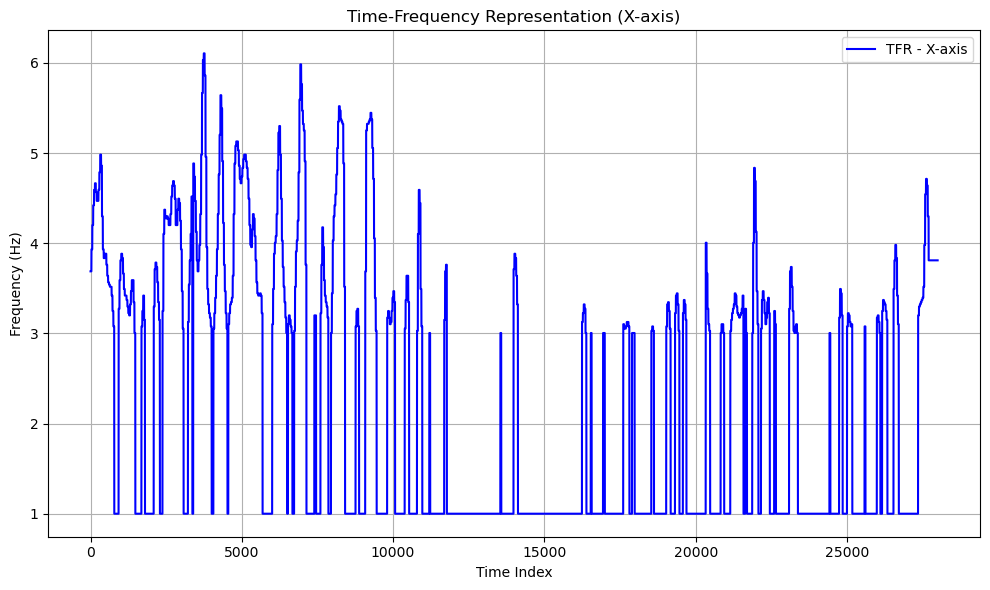

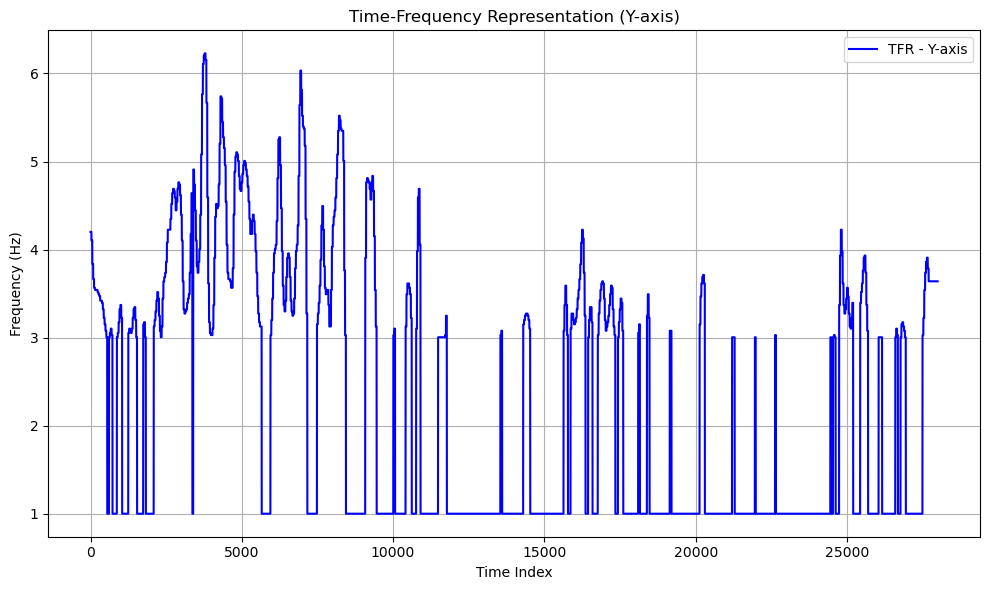

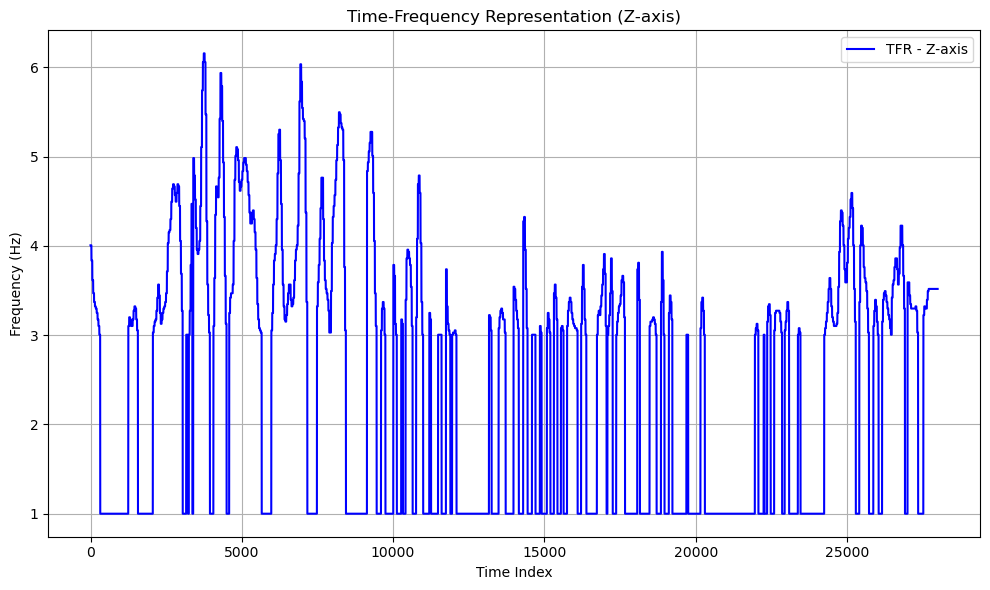

In [13]:
def map_windows_to_timesteps(dominant_frequencies_all_axes, window_size, overlap_ratio, n_timesteps):
    """
    Maps window-based dominant frequencies to the original time scale of n_timesteps.
    The dominant frequency for each window segment is upsampled to match the
    length of the original accelerometer data. This results in a time-frequency representation
    of the accelerometer data across the three axes.

    Args:
        dominant_frequencies_all_axes: 2D array (3 x num_windows), dominant frequencies per axis.
        window_size (int): Number of samples per window.
        overlap_ratio (float): Fraction of overlap between consecutive windows.
        n_timesteps (int): Total number of time samples in the original signal.

    Returns:
        time_freq_map: 2D array (3 x n_timesteps), mapped time-frequency representation.
    """
    step_size = int(window_size * (1 - overlap_ratio))  # Step size between windows
    n_windows = dominant_frequencies_all_axes.shape[1]  # Number of windows
    n_channels = dominant_frequencies_all_axes.shape[0]  # Number of axes (X, Y, Z)

    # Initialize output array
    time_freq_map = np.zeros((n_channels, n_timesteps))

    for ch in range(n_channels):  # Process each axis independently
        for i in range(n_windows):
            # Calculate the range of timesteps covered by the current window
            start_idx = i * step_size
            end_idx = min(start_idx + window_size, n_timesteps)
            
            # Assign the dominant frequency to all timesteps in the window range
            time_freq_map[ch, start_idx:end_idx] = dominant_frequencies_all_axes[ch, i]

    return time_freq_map

# Example usage
n_timesteps = accelerometer_data.shape[1]  # Get the original length of the signal
mapped_time_frequency_representation = map_windows_to_timesteps(
    dominant_frequencies_all_axes, window_size=3*fs, overlap_ratio=0.9, n_timesteps=n_timesteps
)

# Visualization for each axis
axis_labels = ["X-axis", "Y-axis", "Z-axis"]
for i, label in enumerate(axis_labels):
    plt.figure(figsize=(10, 6))
    plt.plot(mapped_time_frequency_representation[i], label=f"TFR - {label}", color="blue")
    plt.title(f"Time-Frequency Representation ({label})")
    plt.xlabel("Time Index")
    plt.ylabel("Frequency (Hz)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


6. Smoothing and Combine axes

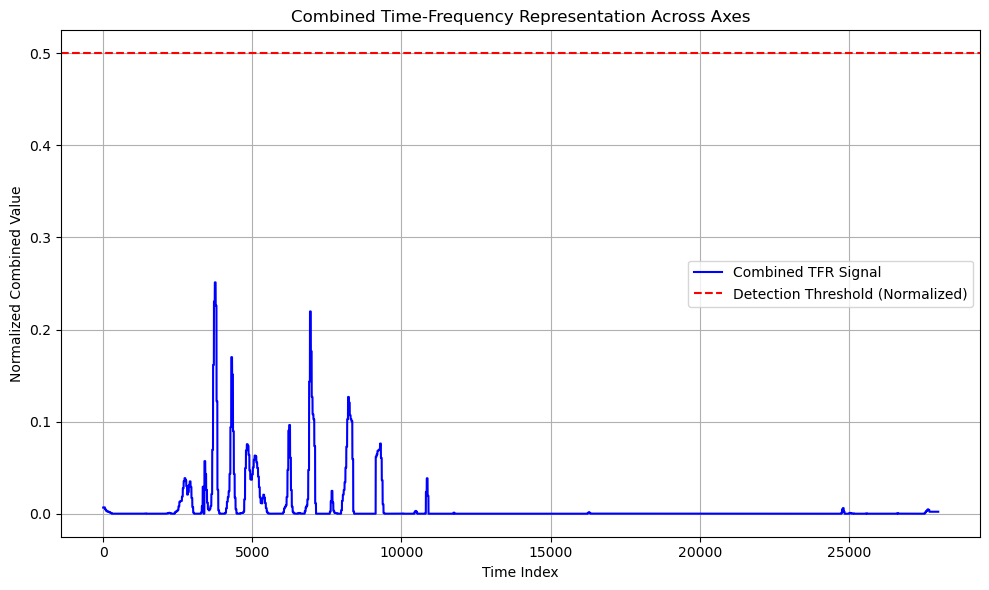

In [14]:
def combine_tfr_axes_with_multiplication(time_freq_map, low_freq=3, high_freq=8):
    """
    Combines the time-frequency representations (TFR) of X, Y, and Z axes using element-wise multiplication.

    Args:
        time_freq_map: 2D array (3 x num_timesteps), mapped TFR signals for each axis.
        low_freq: Lower bound of the tremor frequency range (Hz).
        high_freq: Upper bound of the tremor frequency range (Hz).

    Returns:
        combined_tfr_signal: 1D array, combined TFR signal across all axes.
    """
    # Normalize the time-frequency representation to range [0, 1]
    def normalize_tfr_signal(tfr_signal, low_freq, high_freq):
        return np.clip((tfr_signal - low_freq) / (high_freq - low_freq), 0, 1)

    # Normalize all three axes
    normalized_signals = [normalize_tfr_signal(axis_signal, low_freq, high_freq) for axis_signal in time_freq_map]

    # Perform element-wise multiplication across axes
    combined_tfr_signal = np.prod(normalized_signals, axis=0)

    return combined_tfr_signal

# Apply the combination function
combined_tfr_signal = combine_tfr_axes_with_multiplication(mapped_time_frequency_representation, low_freq=3, high_freq=8)

# Visualization: Combined Time-Frequency Representation
plt.figure(figsize=(10, 6))
plt.plot(combined_tfr_signal, label="Combined TFR Signal", color="blue")
plt.axhline(y=0.5, color="red", linestyle="--", label="Detection Threshold (Normalized)")
plt.title("Combined Time-Frequency Representation Across Axes")
plt.xlabel("Time Index")
plt.ylabel("Normalized Combined Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


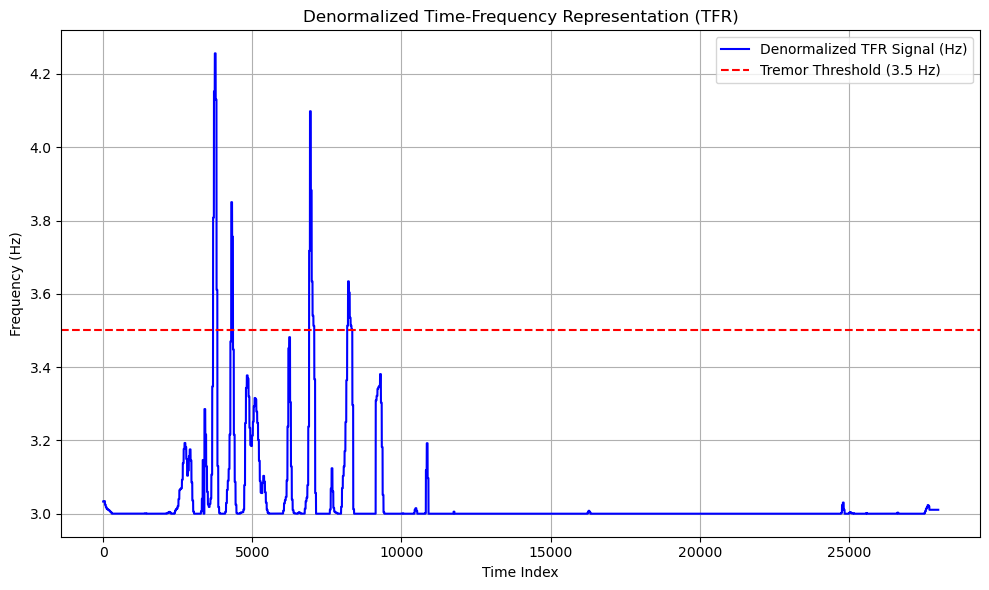

In [15]:
def denormalize_tfr_signal(normalized_signal, low_freq=3, high_freq=8):
    """
    Converts a normalized TFR signal (0-1 scale) back into the actual frequency range (3-8 Hz).

    Args:
        normalized_signal: 1D array, the combined normalized TFR signal.
        low_freq: Lower bound of the tremor frequency range (Hz).
        high_freq: Upper bound of the tremor frequency range (Hz).

    Returns:
        denormalized_signal: 1D array, converted back to real frequency values (3-8 Hz).
    """
    return normalized_signal * (high_freq - low_freq) + low_freq

# Apply denormalization
denormalized_tfr_signal = denormalize_tfr_signal(combined_tfr_signal, low_freq=3, high_freq=8)

# Visualization: Denormalized TFR Signal
plt.figure(figsize=(10, 6))
plt.plot(denormalized_tfr_signal, label="Denormalized TFR Signal (Hz)", color="blue")
plt.axhline(y=3.5, color="red", linestyle="--", label="Tremor Threshold (3.5 Hz)")
plt.title("Denormalized Time-Frequency Representation (TFR)")
plt.xlabel("Time Index")
plt.ylabel("Frequency (Hz)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


7. Thresholding

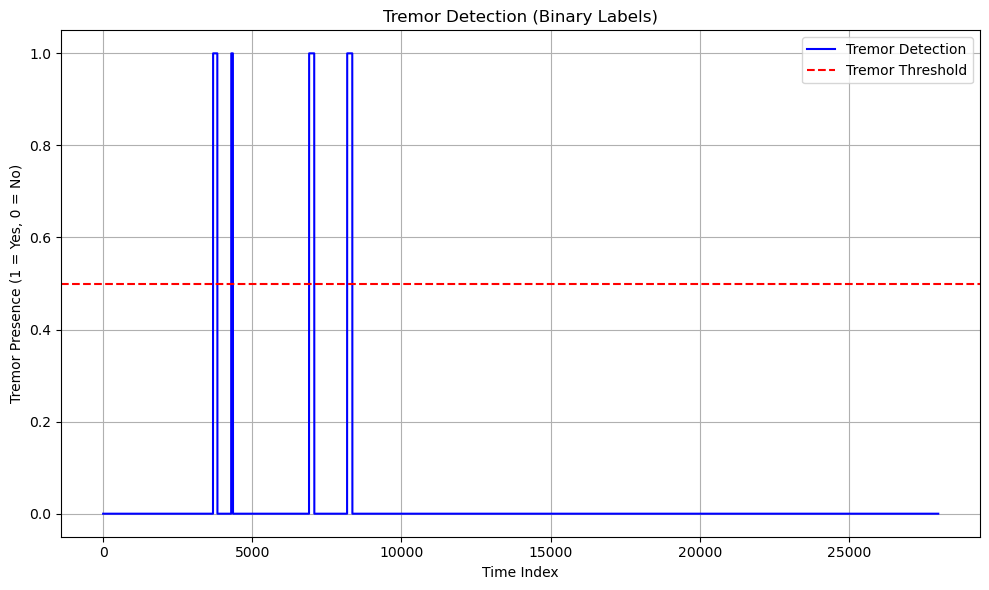

In [16]:
def apply_tremor_threshold(denormalized_signal, threshold=3.5):
    """
    Applies a threshold to classify tremor (T > 3.5 Hz) vs. non-tremor (T < 3.5 Hz).

    Args:
        denormalized_signal: 1D array, the denormalized TFR signal (in Hz).
        threshold: Frequency threshold for tremor detection (default: 3.5 Hz).

    Returns:
        tremor_labels: 1D binary array (1 = Tremor, 0 = Non-Tremor).
    """
    tremor_labels = (denormalized_signal > threshold).astype(int)
    return tremor_labels

# Apply thresholding
tremor_labels = apply_tremor_threshold(denormalized_tfr_signal, threshold=3.5)

# 📊 Visualization: Tremor Labels Over Time
plt.figure(figsize=(10, 6))
plt.plot(tremor_labels, label="Tremor Detection", color="blue")
plt.axhline(y=0.5, color="red", linestyle="--", label="Tremor Threshold")
plt.title("Tremor Detection (Binary Labels)")
plt.xlabel("Time Index")
plt.ylabel("Tremor Presence (1 = Yes, 0 = No)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


8. Rectangular Pulse Representation

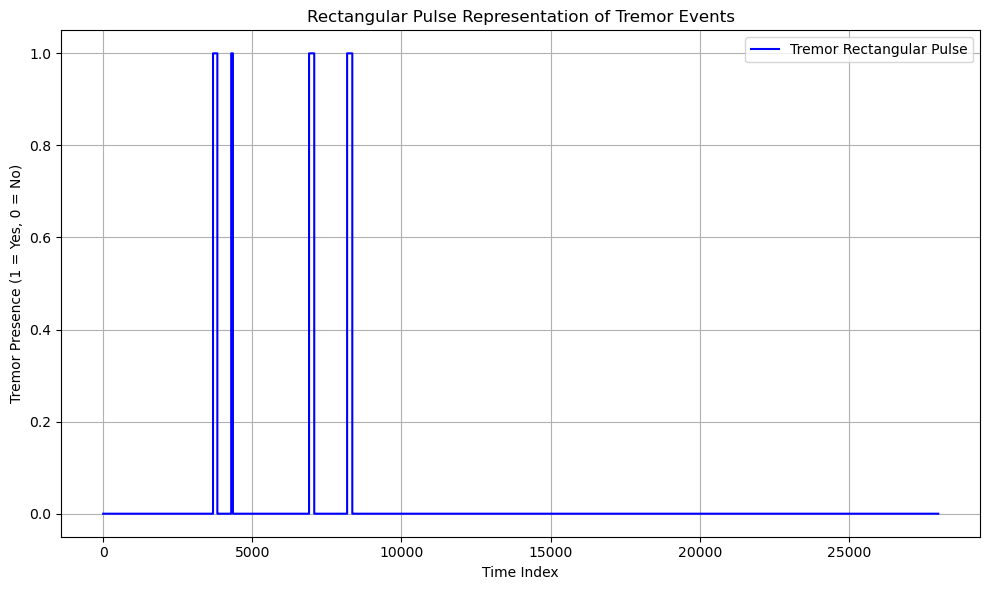

In [17]:
def generate_rectangular_pulse(tremor_labels):
    """
    Converts tremor detection labels into a rectangular pulse representation.

    Args:
        tremor_labels: 1D binary array (1 = Tremor, 0 = Non-Tremor).

    Returns:
        pulse_signal: 1D array, rectangular pulse representation.
    """
    pulse_signal = np.zeros_like(tremor_labels)  # Initialize signal

    # Identify start and end indices of tremor events
    is_tremor = False
    for i in range(len(tremor_labels)):
        if tremor_labels[i] == 1 and not is_tremor:
            is_tremor = True  # Tremor starts
        elif tremor_labels[i] == 0 and is_tremor:
            is_tremor = False  # Tremor ends
        
        if is_tremor:
            pulse_signal[i] = 1  # Maintain tremor region

    return pulse_signal

# Generate rectangular pulses
pulse_signal = generate_rectangular_pulse(tremor_labels)

# Visualization: Rectangular Pulse Representation
plt.figure(figsize=(10, 6))
plt.plot(pulse_signal, label="Tremor Rectangular Pulse", color="blue", drawstyle="steps-post")
plt.title("Rectangular Pulse Representation of Tremor Events")
plt.xlabel("Time Index")
plt.ylabel("Tremor Presence (1 = Yes, 0 = No)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


9. Edge and Duration Calculation for Each Pulse and Tremore Onset Time Extraction

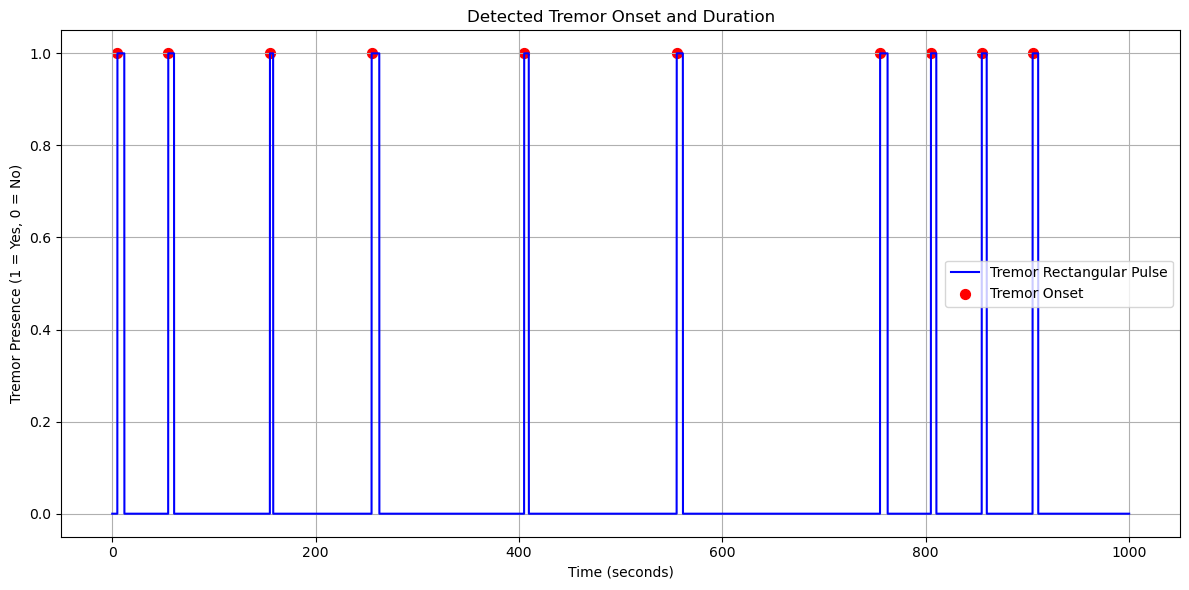

In [18]:
# Re-import necessary libraries after execution state reset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def detect_tremor_edges_and_durations(rectangular_pulse, time_index, min_duration=3, fs=100):
    """
    Detects tremor onset and duration based on the rectangular pulse representation.
    
    Args:
        rectangular_pulse: 1D array of binary tremor presence (1 = tremor, 0 = no tremor).
        time_index: 1D array of corresponding time indices.
        min_duration: Minimum duration (in seconds) for a detected tremor episode.
        fs: Sampling frequency (Hz).
    
    Returns:
        tremor_onsets: List of detected tremor onset times.
        tremor_durations: List of corresponding tremor durations.
    """
    # Detect edges where the signal transitions from 0 → 1 (tremor start) and 1 → 0 (tremor end)
    tremor_starts = np.where((rectangular_pulse[:-1] == 0) & (rectangular_pulse[1:] == 1))[0] + 1
    tremor_ends = np.where((rectangular_pulse[:-1] == 1) & (rectangular_pulse[1:] == 0))[0] + 1

    # Ensure each start has an end
    if len(tremor_ends) > 0 and len(tremor_starts) > 0:
        if tremor_ends[0] < tremor_starts[0]:  # If there's an end before a start, remove it
            tremor_ends = tremor_ends[1:]
        if len(tremor_starts) > len(tremor_ends):  # If a tremor starts but doesn't end, remove last start
            tremor_starts = tremor_starts[:-1]

    # Compute durations and filter out short tremors
    tremor_durations = (tremor_ends - tremor_starts) / fs  # Convert from samples to seconds
    valid_indices = np.where(tremor_durations >= min_duration)[0]

    # Store only valid tremor onsets and durations
    tremor_onsets = time_index[tremor_starts[valid_indices]]
    tremor_durations = tremor_durations[valid_indices]

    return tremor_onsets, tremor_durations

# Example data simulation
fs = 100  # Sampling frequency in Hz
min_duration = 3  # Minimum tremor duration in seconds
num_samples = 100000  # Total number of samples

# Generate a synthetic rectangular pulse signal for demonstration
np.random.seed(42)
rectangular_pulse = np.zeros(num_samples)
tremor_segments = np.random.choice(range(500, num_samples-500, 5000), size=10, replace=False)

for start in tremor_segments:
    end = min(start + np.random.randint(300, 800), num_samples)
    rectangular_pulse[start:end] = 1

# Assuming `time_index` represents the time for each sample
time_index = np.arange(num_samples) / fs  # Convert to seconds

# Detect tremor onset times and durations
tremor_onsets, tremor_durations = detect_tremor_edges_and_durations(rectangular_pulse, time_index, min_duration, fs)

# Visualization of detected tremor events
plt.figure(figsize=(12, 6))
plt.plot(time_index, rectangular_pulse, label="Tremor Rectangular Pulse", color="blue")

# Mark tremor onset times
plt.scatter(tremor_onsets, np.ones_like(tremor_onsets), color='red', label="Tremor Onset", marker='o', s=50)

plt.title("Detected Tremor Onset and Duration")
plt.xlabel("Time (seconds)")
plt.ylabel("Tremor Presence (1 = Yes, 0 = No)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display detected tremor onsets and durations
tremor_events_df = pd.DataFrame({"Tremor Onset (s)": tremor_onsets, "Duration (s)": tremor_durations})


In [31]:
tremor_events_df


,Tremor Onset (s),Duration (s)
0,5.0,6.85
1,55.0,5.76
2,155.0,3.21
3,255.0,7.59
4,405.0,4.60
5,555.0,6.13
6,755.0,7.43
7,805.0,5.35
8,855.0,4.91
9,905.0,5.52


10. Compare label with the test data result

In [29]:
df_result = df[['Result']].astype('float64')
df_result.info(), df_result.head()

data_label = df_result.T.values.astype(np.float32)
ground_truth_labels = df["Result"].values.astype(int)  # Convert to binary (0 = No tremor, 1 = Tremor)

ground_truth_labels

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27995 entries, 0 to 27994
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Result  27995 non-null  float64
dtypes: float64(1)
memory usage: 218.8 KB


array([1, 1, 1, ..., 0, 1, 0])

Accuracy: 0.5056
Precision: 0.5502
Recall: 0.5054
F1 Score: 0.5268


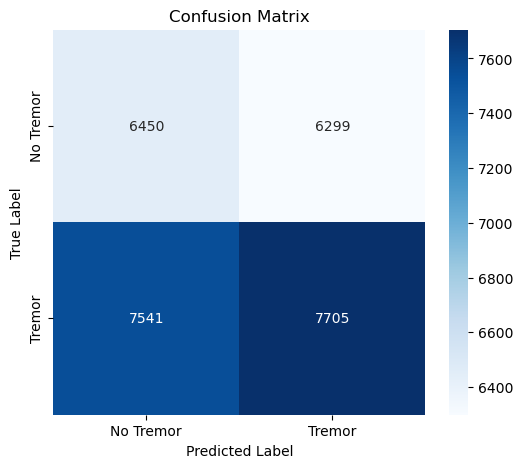

In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Assuming `detected_tremor` is your algorithm's binary output (same length as ground_truth_labels)
# Example (Replace this with your actual detected tremor results)
detected_tremor = np.random.randint(0, 2, size=len(ground_truth_labels))  # Dummy random detection for testing

# Compute Evaluation Metrics
conf_matrix = confusion_matrix(ground_truth_labels, detected_tremor)
accuracy = accuracy_score(ground_truth_labels, detected_tremor)
precision = precision_score(ground_truth_labels, detected_tremor)
recall = recall_score(ground_truth_labels, detected_tremor)
f1 = f1_score(ground_truth_labels, detected_tremor)

# Display Results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tremor", "Tremor"], yticklabels=["No Tremor", "Tremor"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# EEG data

In [21]:
# Filtering
# Define moving avergae filter
def moving_average_filter(data, window_size):
  b = np.ones(window_size) / window_size
  a = [1]
  return lfilter(b, a, data)

# Define bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, numtaps=101):
    taps = firwin(numtaps, [lowcut, highcut], pass_zero=False, fs=fs)
    filtered_data = lfilter(taps, 1.0, data)
    return filtered_data

# Define data segmentation
def segment_data(data, fs, overlap):

  window_size = int(3 * fs)
  step_size = int(window_size * (1 - overlap))
  num_windows = (len(data) - window_size) // step_size + 1
  hamming_window = hamming(window_size)
  segments = np.array([data[i:i + window_size] * hamming_window for i in range(0, len(data) - window_size + 1, step_size)])

  return segments

In [22]:
# apply filters and segmentation to each axis in data
# store transformed data into a numpy array

acc_data = []
for axis in accelerometer_data:

  axis = moving_average_filter(axis, window_size = 100)
  axis = bandpass_filter(axis, lowcut=1, highcut=30, fs=500, numtaps=101)
  axis = segment_data(axis, fs = 500, overlap=0.9)
  acc_data.append(axis)

acc_data = np.array(acc_data)

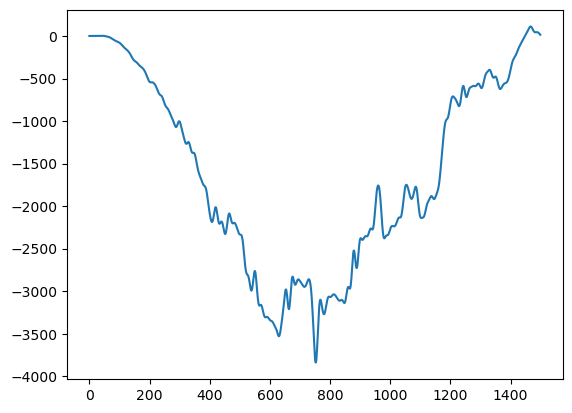

In [23]:
# plot sample window
x = list(range(1500))
plt.plot(x, acc_data[0][0])

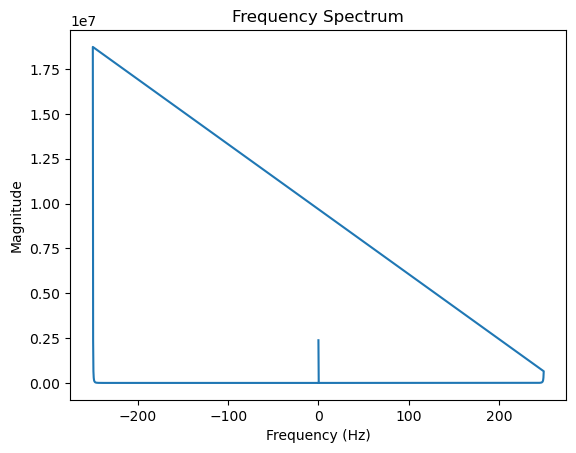

In [24]:
# plot frequency spectrum for sample window
window = acc_data[1][3]

# create frequency spectrum
ar_coeffs,_,_ = aryule(window, 6)
psd = arma2psd(ar_coeffs, NFFT = len(window), sides = 'centerdc') # y-values
freq = np.fft.fftfreq(len(psd), d=1/500) # x-values

# plot spectrum
plt.plot(freq, psd)
plt.title("Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

In [25]:
#4
def label(window, sampling_frequency = 500, tremor_min_freq = 3, tremor_max_freq = 8, ar_order = 6):

  labelled_windows = []

  # create frequency spectrum
  ar_coeffs,_,_ = aryule(window, ar_order)
  psd = arma2psd(ar_coeffs, NFFT = len(window)) # y-values
  psd = np.abs(psd)
  freq = np.fft.fftfreq(window.shape[0], d=1/sampling_frequency) # x-values


  # locate index of tallest peak
  peak_idx,_ = find_peaks(psd) # index of all peaks
  peak_heights = psd[peak_idx] # height of all peaks

  if len(peak_idx) == 0:
    return [1]

  tallest_peak_index = np.argmax(peak_heights)
  tallest_peak_freq = freq[tallest_peak_index] # frequency corresponding to tallest peak

  # compute threshhold
  T = peak_heights[tallest_peak_index] / 10

  # append window-label pair to list
  if (3 <= tallest_peak_freq <= 8) and (T):
    label = 0
    labelled_windows.append((window,label))
  else:
    label = 1
    labelled_windows.append((window,label))

  return labelled_windows

In [26]:
#5
def dominant_peaks(window, sampling_frequency = 500, tremor_min_freq = 3, tremor_max_freq = 8, ar_order = 6):

  # create frequency spectrum
  ar_coeffs, _, _ = aryule(window, 6)
  psd = arma2psd(ar_coeffs, NFFT=len(window), sides='centerdc') # y-values
  psd = np.abs(psd)
  freq = np.fft.fftfreq(window.shape[0], d=1/sampling_frequency) # x-values


  # locate index of tallest peak
  peak_idx,_ = find_peaks(psd) # index of all peaks
  peak_heights = psd[peak_idx] # height of all peaks


  tallest_peak_index = np.argmax(peak_heights)
  tallest_peak_freq = freq[tallest_peak_index] # frequency corresponding to tallest peak


  # compute threshhold
  T = peak_heights[tallest_peak_index] / 10

  # obtain dominant peak
  if (3 <= tallest_peak_freq <= 8):
    dominant_peak = tallest_peak_freq
  else:
    dominant_peak = 1

  return dominant_peak

In [27]:
for axis in acc_data:
  axis_peaks = [] # stores dominant peaks of all axis
  for window in axis:
    window_peaks = [] # stores dominant peak of each window in axis
    peaks = dominant_peaks(window)
    window_peaks.append(peaks)
    print(window_peaks)
  axis_peaks.append(window_peaks)

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


# EEG

In [28]:
# access eeg data for one trial
eeg_file_path = '/content/drive/My Drive/NeuroTechUofT24/eeg_data/801_2_PD_REST-epo.fif'

# load the data
raw = mne.io.read_raw_fif(eeg_file_path, preload=True)

Opening raw data file /content/drive/My Drive/NeuroTechUofT24/eeg_data/801_2_PD_REST-epo.fif...


/var/folders/lm/g0fsyqm52tjf6q4x94d9mdvw0000gn/T/ipykernel_6706/3162475012.py:5: RuntimeWarning: This filename (/content/drive/My Drive/NeuroTechUofT24/eeg_data/801_2_PD_REST-epo.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file_path, preload=True)


FileNotFoundError: fname does not exist: "/content/drive/My Drive/NeuroTechUofT24/eeg_data/801_2_PD_REST-epo.fif"

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


<ipython-input-18-e6057b300350>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()


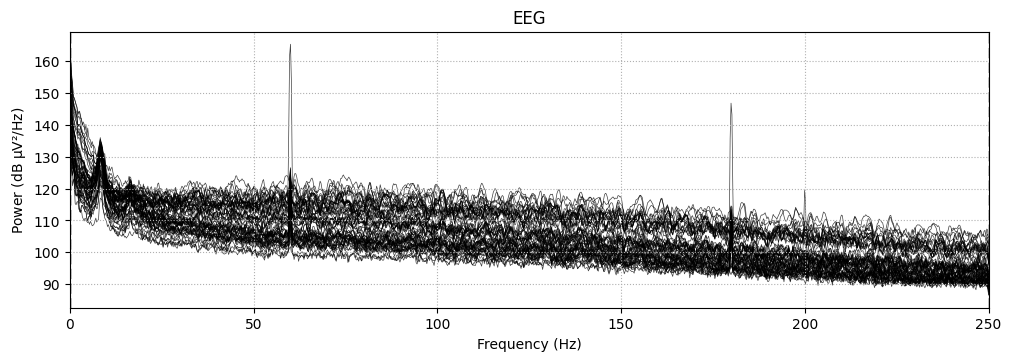

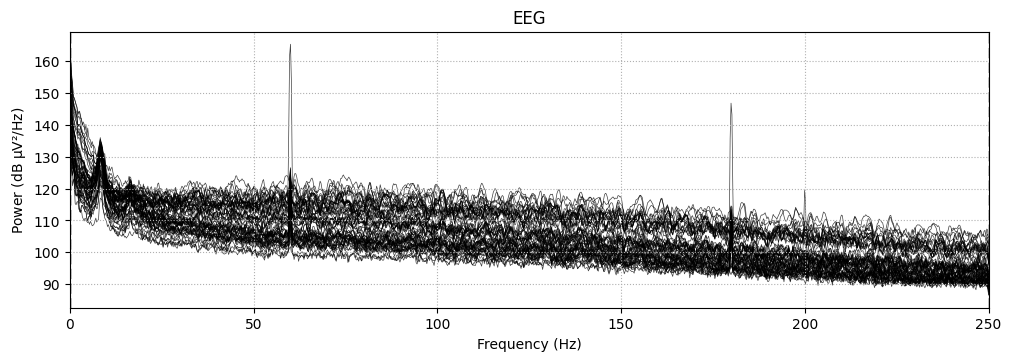

In [ ]:
raw.compute_psd().plot()

Using matplotlib as 2D backend.


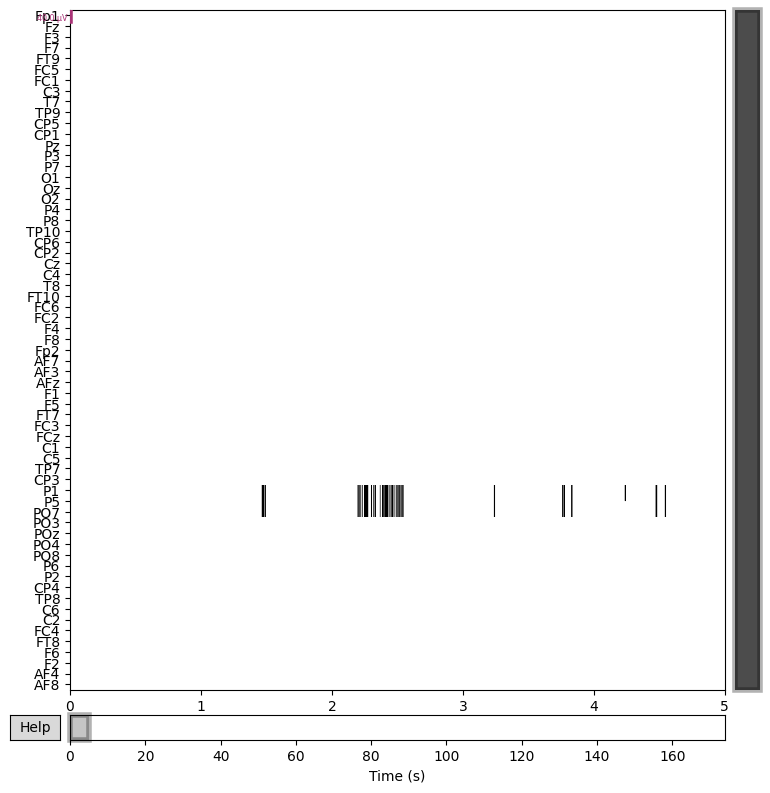

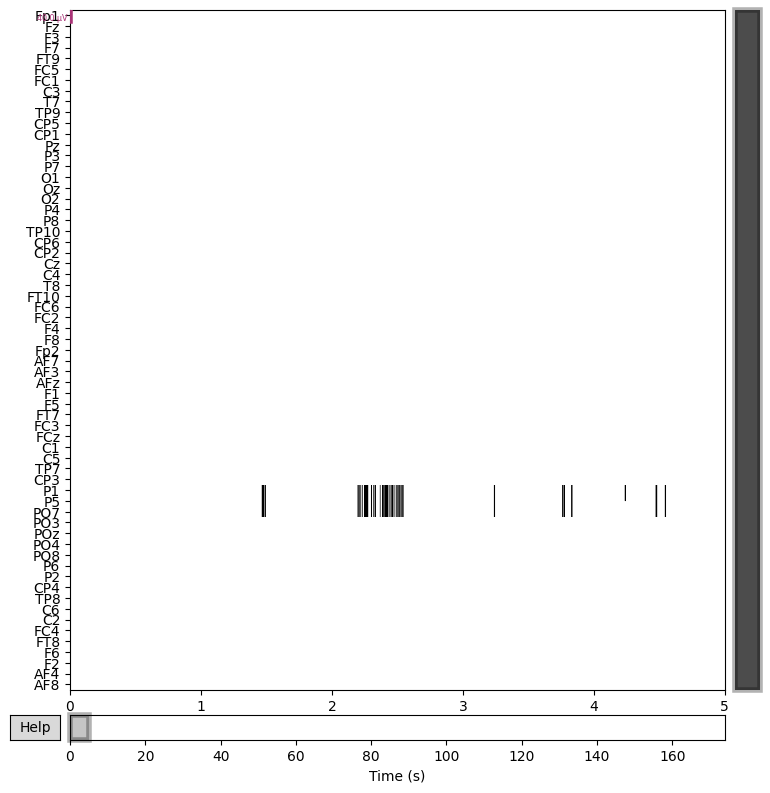

In [ ]:
raw.plot(duration=5, proj=False, n_channels=len(raw.ch_names), remove_dc=False)

In [ ]:
# bandpass filtering
raw.filter(l_freq=1.0, h_freq=40.0)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


<Raw | 801_2_PD_REST-epo.fif, 63 x 87001 (174.0 s), ~41.9 MiB, data loaded>

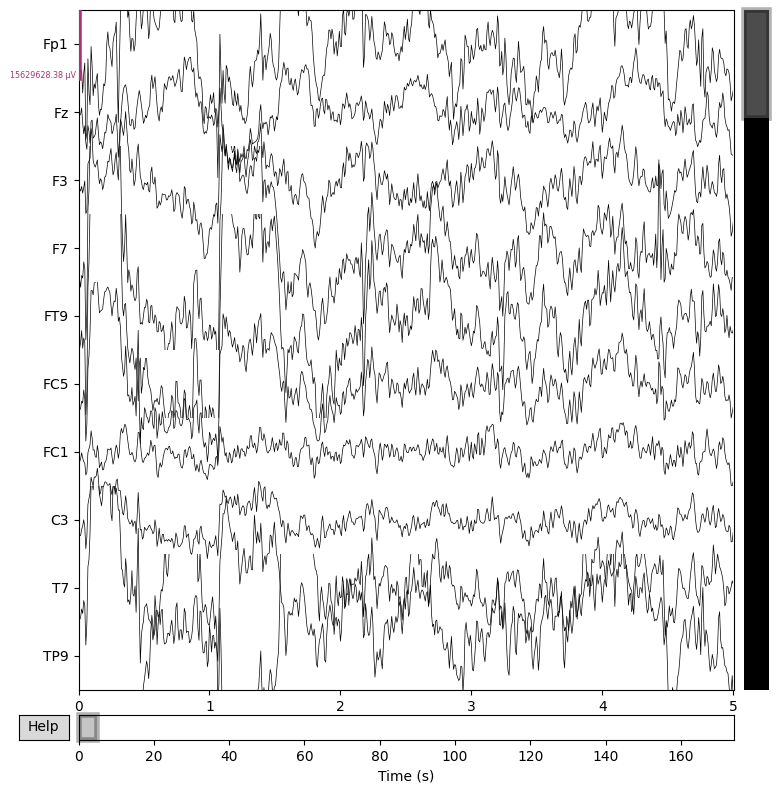

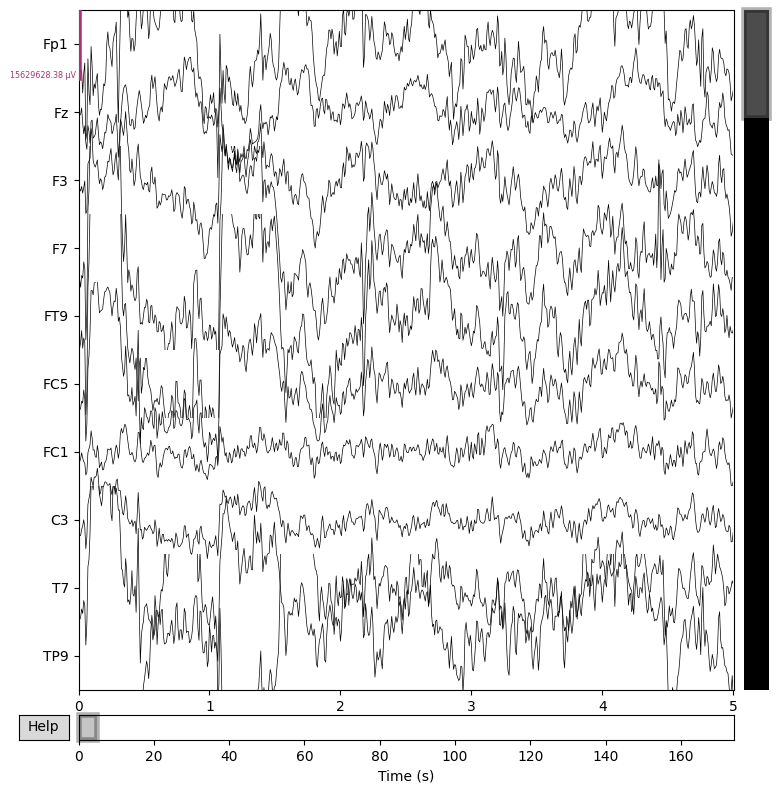

In [ ]:
raw.plot(n_channels=10, duration=5, remove_dc = True, scalings='auto')

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 7.8s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated


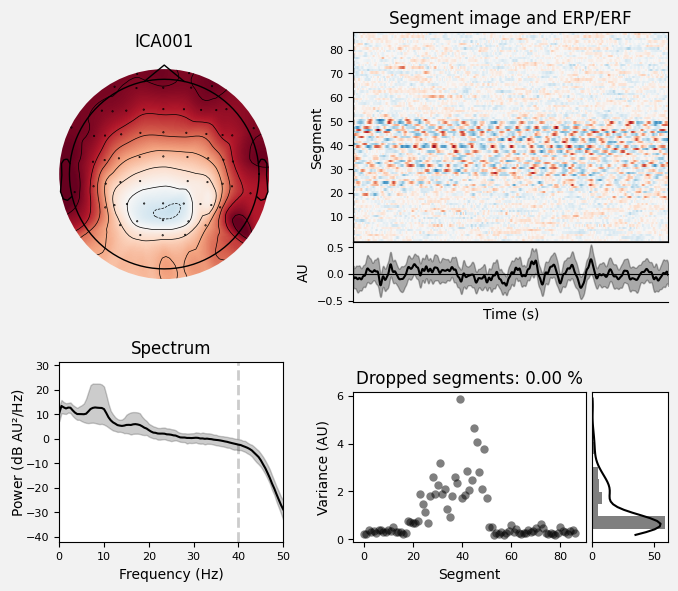

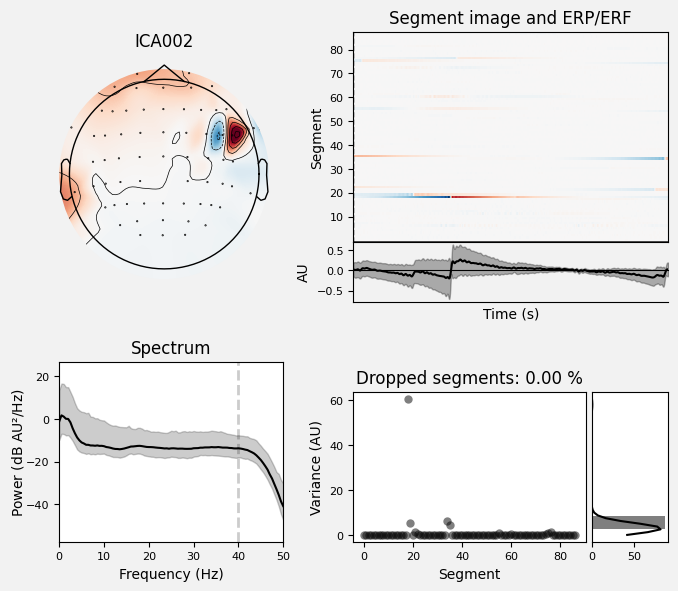

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [ ]:
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
# pick some random components, see https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#tut-artifact-ica for how to really
# choose the best components to exclude for our data when applying ICA
ica.exclude = [1, 2]
ica.plot_properties(raw, picks=ica.exclude)

# New Section

1.


In [ ]:
from scipy.signal import lfilter

def moving_average_filter(data, window_size=100):
    b = [1.0 / window_size] * window_size
    a = 1
    return lfilter(b, a, data)

for i in range(saved_eeg_data.shape[0]):
    saved_eeg_data[i, :] = moving_average_filter(saved_eeg_data[i, :], window_size=500)


NameError: name 'saved_eeg_data' is not defined

2.

In [ ]:
from scipy.signal import firwin, filtfilt

def bandpass_filter(data, lowcut=1, highcut=30, fs=500, order=100):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b = firwin(order + 1, [low, high], pass_zero=False)
    return filtfilt(b, [1.0], data)

for i in range(saved_eeg_data.shape[0]):
    saved_eeg_data[i, :] = bandpass_filter(saved_eeg_data[i, :])

3.

In [ ]:
from scipy.signal import hamming

def segment_data(data, window_size=1500, overlap=0.9, fs=500):
    step_size = int(window_size * (1 - overlap))
    segments = []
    for start in range(0, data.shape[1] - window_size + 1, step_size):
        segment = data[:, start:start + window_size] * hamming(window_size)
        segments.append(segment)
    return np.array(segments)

segmented_data = segment_data(saved_eeg_data)

4.

In [ ]:
#4
from spectrum import aryule, arma2psd
import numpy as np

def estimate_tremor(window, fs=100, low_freq=3, high_freq=8, ar_order=6):
    # Berg's method
    ar_coeffs, _, _ = aryule(window, ar_order)

    #Compute the power spectral density (PSD) from AR coefficients
    psd = arma2psd(ar_coeffs, sides='centerdc')

    # Convert PSD to frequencies
    freq_bins = np.fft.fftfreq(len(psd), d=1/fs)  # Generate frequency bins
    psd = np.abs(psd)  # Ensure PSD values are positive

    # Select frequencies in the range (3–8 Hz)
    tremor_indices = np.where((freq_bins >= low_freq) & (freq_bins <= high_freq))[0]
    freqs = freq_bins[tremor_indices]
    psd_tremor = psd[tremor_indices]

    return freqs, psd_tremor


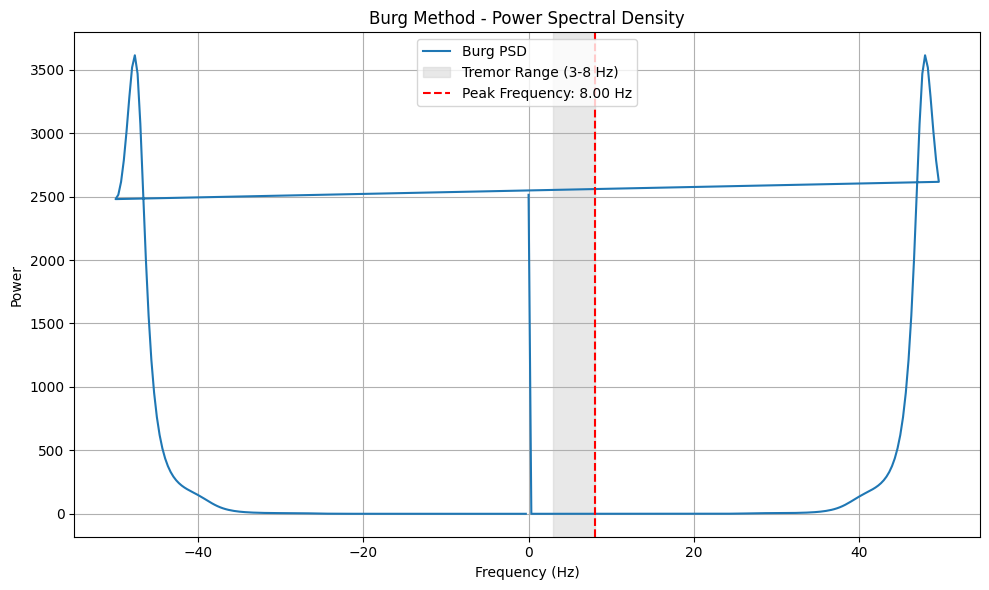

Detected Peak Frequency: 8.00 Hz


In [ ]:
from spectrum import aryule, arma2psd
import numpy as np
import matplotlib.pyplot as plt

# Example signal processing and plotting
fs = 100  # Sampling frequency in Hz
low_freq = 3
high_freq = 8
ar_order = 6

# Use one of your Hamming-windowed segments as the input
window = segmented_signal[0]  # Replace with a real segment

# Step 1: Estimate autoregressive coefficients using Burg method
ar_coeffs, _, _ = aryule(window, ar_order)

# Step 2: Compute power spectral density (PSD) from AR coefficients
psd = arma2psd(ar_coeffs, NFFT=len(window), sides='centerdc')
psd = np.abs(psd)  # Ensure PSD is non-negative

# Step 3: Generate corresponding frequency bins
freq_bins = np.fft.fftfreq(len(psd), d=1/fs)

# Step 4: Filter PSD and frequencies to focus on the 3–8 Hz range
valid_indices = np.where((freq_bins >= low_freq) & (freq_bins <= high_freq))
psd_filtered = psd[valid_indices]
freq_filtered = freq_bins[valid_indices]

# Step 5: Find the peak frequency in the filtered PSD
if len(psd_filtered) > 0:
    peak_index = np.argmax(psd_filtered)
    peak_frequency = freq_filtered[peak_index]

    # Step 6: Plot the PSD and mark the peak frequency
    plt.figure(figsize=(10, 6))
    plt.plot(freq_bins, psd, label="Burg PSD")
    plt.axvspan(low_freq, high_freq, color='lightgray', alpha=0.5, label="Tremor Range (3-8 Hz)")
    plt.axvline(peak_frequency, color='red', linestyle='--', label=f"Peak Frequency: {peak_frequency:.2f} Hz")
    plt.title("Burg Method - Power Spectral Density")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Detected Peak Frequency: {peak_frequency:.2f} Hz")
else:
    print("No peak frequency detected in the 3–8 Hz range.")
